In [13]:
import torch
import os
from settings import BASE_DIR
import numpy as np
import json
import csv
import itertools
import albumentations as A
import cv2
from PIL import Image
from settings import BASE_DIR
import matplotlib.pyplot as plt

In [111]:
def plot_img(image, landmarks=None, circles=None):
    """
    image: np.array of shape (n, m)
    landmarks: np.array of shape (n, 2)
    circles: np.array of shape (n, 3)
    """
    plt.imshow(image)
    if landmarks is not None and len(landmarks) > 0:
        x = landmarks[:, 0]
        y = landmarks[:, 1]
        plt.scatter(x, y)
    if circles is not None and len(circles) > 0:
        for circle in circles:
            xc, yc, r = circle
            plt.gca().add_patch(plt.Circle((xc, yc), r, fill=False))



In [213]:
transform = A.Compose (
    [
        A.ToGray(p=1),
        # A.Resize(height=300, width=400),
        A.RandomSizedCrop(min_max_height=(250, 250), height=300, width=400, p=0.5),
        # A.CenterCrop(height=200, width=200),
        A.Rotate(limit=40, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomScale(p=1),
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

In [27]:
data_dir = f'{BASE_DIR}/data/pupil'
images_dir = f'{data_dir}/images'
labels_path = f'{data_dir}/labels.json'

In [5]:
with open(labels_path) as json_file:
    data = json.load(json_file)

In [9]:
image_names_list = sorted(list(data.keys()))

In [7]:
image = Image.open(f'{images_dir}/{image_names_list[0]}.tiff')

In [10]:
images_list = [image]
image_ = np.array(image)

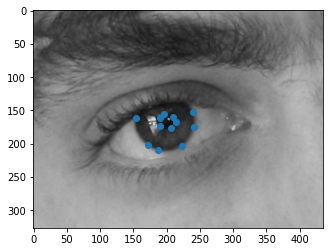

In [239]:
inner_landmarks = data[image_names_list[0]]['inner']['landmarks']
outer_landmarks = data[image_names_list[0]]['outer']['landmarks']
augmentations = transform(image=image_, keypoints=inner_landmarks + outer_landmarks)
augmented_img = augmentations['image']
plt.imshow(augmented_img)
plot_img(augmented_img, landmarks=np.array(augmentations['keypoints']))

In [141]:
image_.shape


(300, 400, 3)